<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Concept%20drift%EC%9D%98%20%ED%83%90%EC%A7%80%20%EB%B0%A9%EB%B2%95_0123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift의 탐지 방법 <br>

concept drift detect method

# 1. Introduction

* Data Drift의 상황에서는 재학습 (retrain)을 하면 되지만, Concept Drift 상황에서는 p(y|x)의 상관관계가 변화되었으므로 새롭게 모델을 학습 즉, remodeling을 해야 한다.
* 하지만, on-line data에 대하여 Drift를 측정(ks-test 등)할 수 있어도, 이 상황이 Data Drift (or virtual concept drift)인지 진짜 Concept Drift인지를 파악하기 어렵다.
* 이런 상황에서 단순히 재학습을 하여 모델을 운영한다면, 역시 성능 회복이 안될 것이며, 이를 인지하지 못한 상태로 모델을 계속 운영할 수 있다.
* 이러한 운영상의 문제점을 극복하기 위해, Concept Drift를 탐지하고자 한다. 












# 2. 이론적 배경



# 3. Proposed Method

## pseudo code

# 4. 실험 계획

*   Data
1. Personal Loan Data
> 미국의 개인 대출 기업 ‘Lending Club’의 공개 데이터 사용<BR>
> 2007~2017년까지 총 2,260,701건의 데이터, 대출 건당 실제 ‘default’ 여부 포함
151개 Column<BR>
> 데이터 정제 후, 81개 Features, 120만건 사용<BR>
>> trainset : 11,497건 (2010년)<BR>
>> online dataset : 1,268,183건 (2011~2017년)<BR>



# 5. 실험을 위한 기본 준비 

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random
np.random.seed(1337)

In [4]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    

# 7. loan predict 실험

## 데이터 구축

In [5]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)


### 데이터 정제

In [6]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


In [7]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

In [8]:
# maybe we can go further, and eliminate columns up to title:

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [9]:
# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [10]:
# These are constant columns. We can drop it either.

cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

In [11]:
# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

In [12]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])


In [13]:
df_accepted

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [14]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [15]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


In [16]:
df_accepted.shape

(1341026, 86)

In [17]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
df_accepted.shape

(1341026, 83)

In [18]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [19]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [20]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

In [21]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1341026 non-null  float64
 1   term                        1341026 non-null  int64  
 2   int_rate                    1341026 non-null  float64
 3   annual_inc                  1341026 non-null  float64
 4   issue_d                     1341026 non-null  object 
 5   dti                         1341026 non-null  float64
 6   delinq_2yrs                 1341026 non-null  float64
 7   fico_range_high             1341026 non-null  float64
 8   inq_last_6mths              1341026 non-null  float64
 9   open_acc                    1341026 non-null  float64
 10  pub_rec                     1341026 non-null  float64
 11  revol_bal                   1341026 non-null  float64
 12  revol_util                  1341026 non-null  float64
 1

In [22]:
df_accepted[['G1','G2','G3','G4']]

,G1,G2,G3,G4
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
1341021,0,0,0,0
1341022,0,0,0,0
1341023,0,0,0,0
1341024,0,0,0,0


### dataset 만들기

In [23]:
X = {}
Y = {}

In [24]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:214: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:
df.shape

(5797, 82)

In [26]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [27]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [28]:
X[2010].shape

(11497, 81)

In [29]:
COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns

In [30]:
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

## 예측 모델 구축

In [31]:
ML = {}
scaler = MinMaxScaler()

In [32]:
MODEL_TYPE = 'RF'  ## RF / DL

### random forest 모델

In [33]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [34]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(X_train,y_train)
    return model

### loan predict model build

In [35]:
seed_everything()

offset = int(Y[2010].shape[0] * 0.7)
y_ref = Y[2010][0:offset]
x_ref = X[2010][0:offset]
y_inf = Y[2010][offset:]
x_inf = X[2010][offset:]

ML[2010] = build_model_rf(year,x_ref,y_ref,epochs=5)

In [36]:
dd = np.zeros((4,4))
# add intercept term
intc = np.ones((dd.shape[0],1))
dd = np.concatenate((dd,intc),axis=1)
dd.shape

(4, 5)

In [37]:
from sklearn.metrics import precision_recall_fscore_support

base_score = precision_recall_fscore_support(y_inf, ML[2010].predict(scaler.transform(x_inf)),average='binary')
base_score

(0.9908045977011494, 1.0, 0.9953810623556583, None)

## loan predict model의 성능 예측 실험

In [38]:
# 2010년의 data를 기준으로 그 이후의 data 들...
X2 = np.concatenate((X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))

In [39]:
print("trainset:",X[2010].shape)
print("online dataset:",X2.shape)

trainset: (11497, 81)
online dataset: (1268183, 81)


## 실험

## **중요!!**


https://interpret.ml/docs/shap.html

#### RF의 feature importance 

In [40]:
importances = ML[2010].feature_importances_
imp_df1 = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

forest_importances = pd.Series(importances, index=COLUMNS)
monitoring_feature = list(forest_importances.sort_values(ascending=False).keys()[0:10])
print(monitoring_feature)

#imp_df1.loc[len(imp_df1)] = importances

#forest_importances.to_dict()
#importances.reshape(-1,1)

imp_df1[monitoring_feature]

['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term', 'Y', 'fico_range_high', 'total_rec_int', 'revol_util']


,recoveries,last_fico_range_high,last_pymnt_amnt,total_rec_late_fee,int_rate,term,Y,fico_range_high,total_rec_int,revol_util
0,0.558539,0.172298,0.094741,0.029876,0.023612,0.022712,0.018601,0.010657,0.008728,0.008422


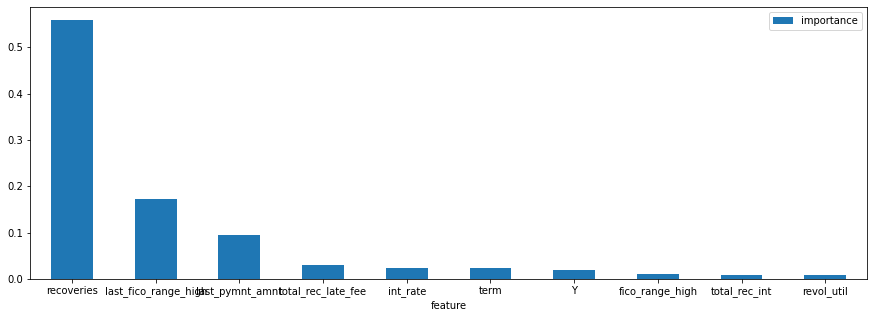

In [41]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df1[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))


#### shap에 의한 feature importance 분석

In [42]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift, ClassifierDrift

#### Tree Explainer

In [43]:
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.fit_transform(x_ref))

In [53]:
x_ref.shape

(8047, 81)

In [52]:
np.asarray(shap_values).shape

(2, 8047, 81)

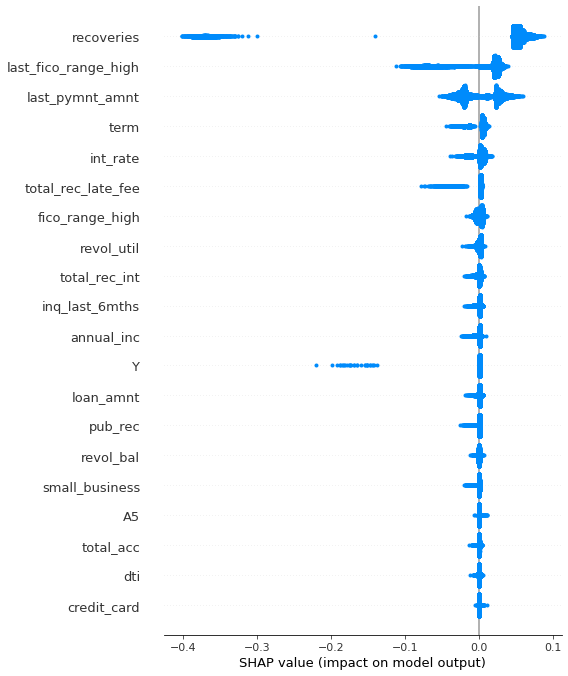

In [46]:
shap.summary_plot(shap_values[1], feature_names=COLUMNS)

In [54]:

vals= np.mean(np.abs(shap_values[1]),axis=0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,vals):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

,recoveries,last_fico_range_high,last_pymnt_amnt,term,int_rate,total_rec_late_fee,fico_range_high,revol_util,total_rec_int,inq_last_6mths
0,0.094812,0.032824,0.024673,0.008705,0.006095,0.004352,0.00343,0.001882,0.001772,0.001544


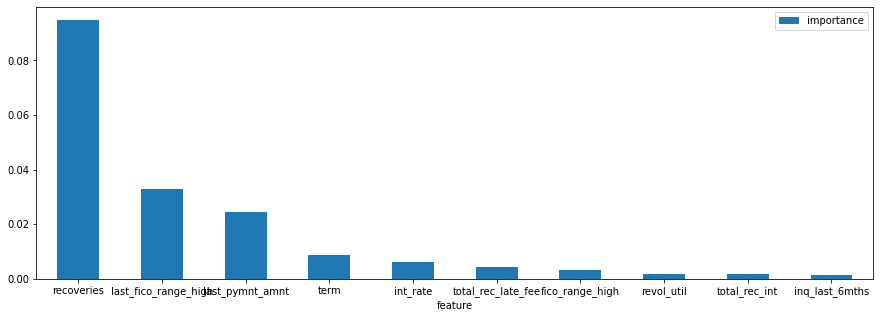

In [55]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))


#### Deep Explainer

In [56]:
explainer = shap.DeepExplainer(ML[2010],scaler.fit_transform(x_ref))
shap_values = explainer.shap_values()
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: ignored

#### interpret

In [40]:
!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
from re import VERBOSE
from interpret import show
from interpret.blackbox import ShapKernel
import shap

scaler = MinMaxScaler()
scaler.fit(x_ref)

x_reff = scaler.transform(x_ref)
background = shap.utils.sample(x_reff, 100)

shapk = ShapKernel(predict_fn=ML[2010].predict, data=background,feature_names=COLUMNS)
shap_local = shapk.explain_local(x_reff[:2],y_ref[:2])

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

In [47]:
show(shap_local)

In [98]:
explainer = shap.KernelExplainer(ML[2010].predict,background)
shap_values = explainer.shap_values(x_reff[:10])
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,vals):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

,recoveries,last_fico_range_high,last_pymnt_amnt,total_rec_int,total_rec_late_fee,fico_range_high,int_rate,term,inq_last_6mths,revol_util
0,0.111655,0.021499,0.015438,0.002976,0.002955,0.00239,0.002132,0.00212,0.00173,0.001707


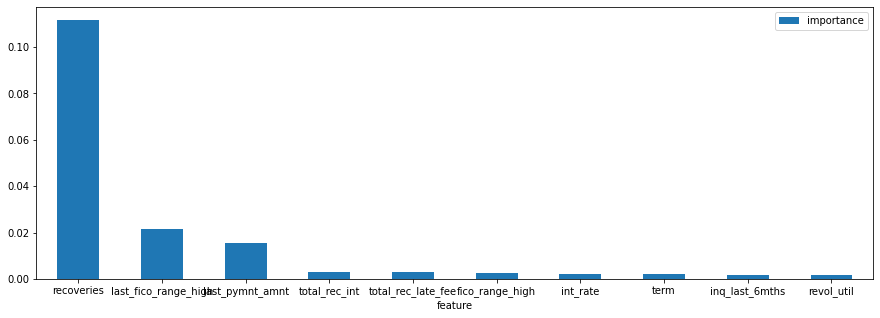

In [99]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))


In [55]:
df_ref = pd.DataFrame(x_reff,columns=COLUMNS)

In [74]:
from interpret.blackbox import MorrisSensitivity

msa = MorrisSensitivity(predict_fn=ML[2010].predict, data=df_ref)
msa_global = msa.explain_global()

show(msa_global)


In [78]:
msa_global.data()['scores'].data

array([0.0075, 0.006 , 0.0135, 0.006 , 0.0045, 0.003 , 0.006 , 0.003 ,
       0.006 , 0.0045, 0.0075, 0.0045, 0.003 , 0.0075, 0.0015, 0.72  ,
       0.0045, 0.024 , 0.    , 0.    , 0.    , 0.    , 0.0015, 0.    ,
       0.    , 0.0045, 0.003 , 0.0075, 0.0015, 0.    , 0.003 , 0.    ,
       0.    , 0.0015, 0.0015, 0.    , 0.003 , 0.    , 0.    , 0.003 ,
       0.0015, 0.    , 0.0015, 0.012 , 0.    , 0.    , 0.0075, 0.0015,
       0.0015, 0.003 , 0.0015, 0.    , 0.    , 0.0045, 0.    , 0.0105,
       0.    , 0.003 , 0.0015, 0.0015, 0.    , 0.    , 0.0015, 0.    ,
       0.0015, 0.    , 0.0075, 0.    , 0.    , 0.006 , 0.006 , 0.0045,
       0.0045, 0.    , 0.0015, 0.0015, 0.    , 0.003 , 0.    , 0.    ,
       0.0195])

#### SHAP Explainer

In [68]:
x_reff = scaler.fit_transform(x_ref)
X100 = shap.utils.sample(x_reff, 100) # 100 instances for use as the background distribution
explainer = shap.Explainer(ML[2010],X100)
shap_values = explainer.shap_values(x_reff)
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 30
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

 99%|===================| 15991/16094 [00:33<00:00]       

,recoveries,last_fico_range_high,last_pymnt_amnt,term,int_rate,total_rec_late_fee,fico_range_high,total_rec_int,Y,revol_util,...,open_acc,E1,credit_card,E4,D2,D3,pub_rec_bankruptcies,A4,MORTGAGE,RENT
0,0.108473,0.031041,0.022515,0.007952,0.005829,0.004996,0.002228,0.002098,0.002074,0.001735,...,0.000371,0.000344,0.000251,0.000213,0.000204,0.000199,0.000188,0.000158,0.00014,0.000139


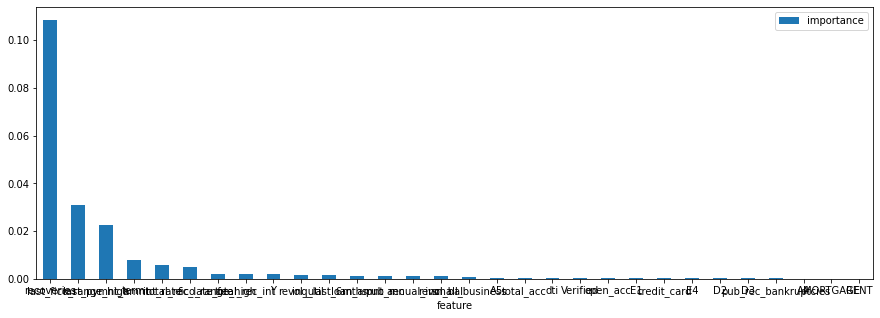

In [69]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))

In [70]:
df

,feature,importance
0,recoveries,0.108473
1,last_fico_range_high,0.031041
2,last_pymnt_amnt,0.022515
3,term,0.007952
4,int_rate,0.005829
5,total_rec_late_fee,0.004996
6,fico_range_high,0.002228
7,total_rec_int,0.002098
8,Y,0.002074
9,revol_util,0.001735


#### Mutual information에 의한 feature importance 분석

In [71]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [64]:
discrete_features = pd.DataFrame(X[2010],columns=COLUMNS).dtypes == int

                       feature  importance
0                   recoveries    0.367660
1              last_pymnt_amnt    0.082367
2         last_fico_range_high    0.081436
3           debt_consolidation    0.038958
4           total_rec_late_fee    0.025793
5                     int_rate    0.022256
6         pub_rec_bankruptcies    0.019126
7             renewable_energy    0.015900
8                           F2    0.014995
9                     vacation    0.014862
10               total_rec_int    0.014851
11                     medical    0.014164
12                          B3    0.012635
13                     wedding    0.012435
14                          D1    0.012223
15                          D5    0.011257
16                           Y    0.011218
17                          B2    0.010954
18                       OTHER    0.009514
19                          G3    0.009106
20                           w    0.008982
21                          A2    0.008901
22         

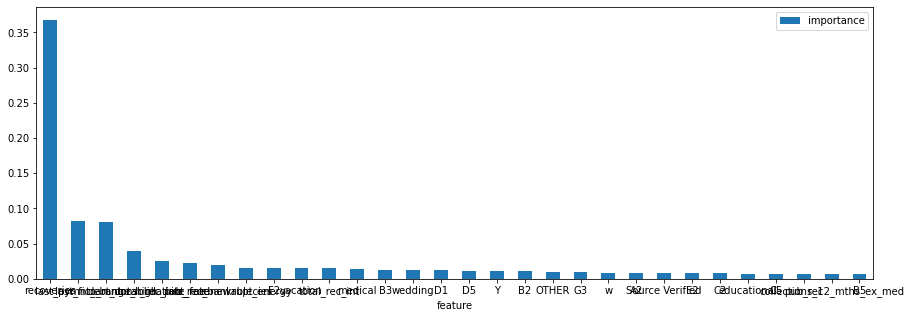

In [73]:
mi_scores = make_mi_scores(pd.DataFrame(scaler.fit_transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))
top=30
imp_df3 = pd.DataFrame({'feature':mi_scores.keys()[:top],'importance':mi_scores.values[:top]})
print(imp_df3)
imp_df3.plot.bar(x='feature',rot=0,figsize=(15,5))

## Random-forest, 성능 추이

각 step 마다의 random-forest, shap, MI의 importance를 측정한다.
ground-truth의 Y를 사용한다.

In [ ]:
import math

batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['prec'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#Random-forest
predict = ML[REFERENCE_YEAR].predict
importances = ML[REFERENCE_YEAR].feature_importances_
#imp_df = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

imp_df_rf = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

# SHAP
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.transform(x_ref))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)
imp_df_sh = pd.DataFrame(feature_importance)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    Y3_ = predict(scaler.transform(X3))
    f1 = precision_recall_fscore_support(Y3, Y3_ ,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['prec'].append(f1[0])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    scaler = MinMaxScaler()
    scaler.fit(X3)

    X3_f = scaler.transform(X3)
    # RF
    model2 = RandomForestClassifier(n_estimators=80,max_depth=5)
    model2.fit(X3_f,Y3)
    imp_df_rf.loc[len(imp_df_rf)] = model2.feature_importances_
    # SHAP
    explainer = shap.TreeExplainer(model2)
    shap_values = explainer.shap_values(X3_f)

    #X100 = shap.utils.sample(X3_f, 100) # 100 instances for use as the background distribution
    #explainer = shap.Explainer(model2,X100)
    #shap_values = explainer.shap_values(X3_f)

    vals= np.abs(shap_values).mean(0)
    imp_df_sh.loc[len(imp_df_sh)] = np.mean(vals,axis=0).reshape(-1,)
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(X3),columns=COLUMNS), Y3, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} prec:{f1[0]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)



127/127 prec:0.8719

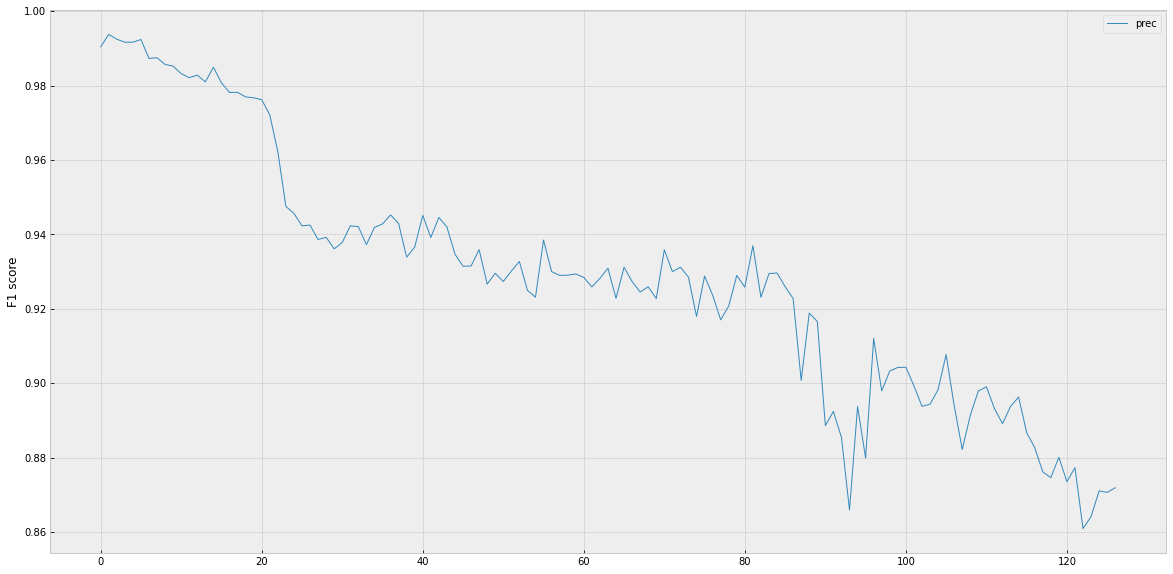

In [ ]:
plt.style.use('bmh')
df1.plot(ylabel='F1 score',linewidth=1,figsize=(20,10))

In [ ]:
monitoring_feature

array(['recoveries', 'last_fico_range_high', 'last_pymnt_amnt', 'term',
       'int_rate', 'total_rec_late_fee', 'fico_range_high',
       'total_rec_int', 'Y', 'revol_util'], dtype='<U26')

[]

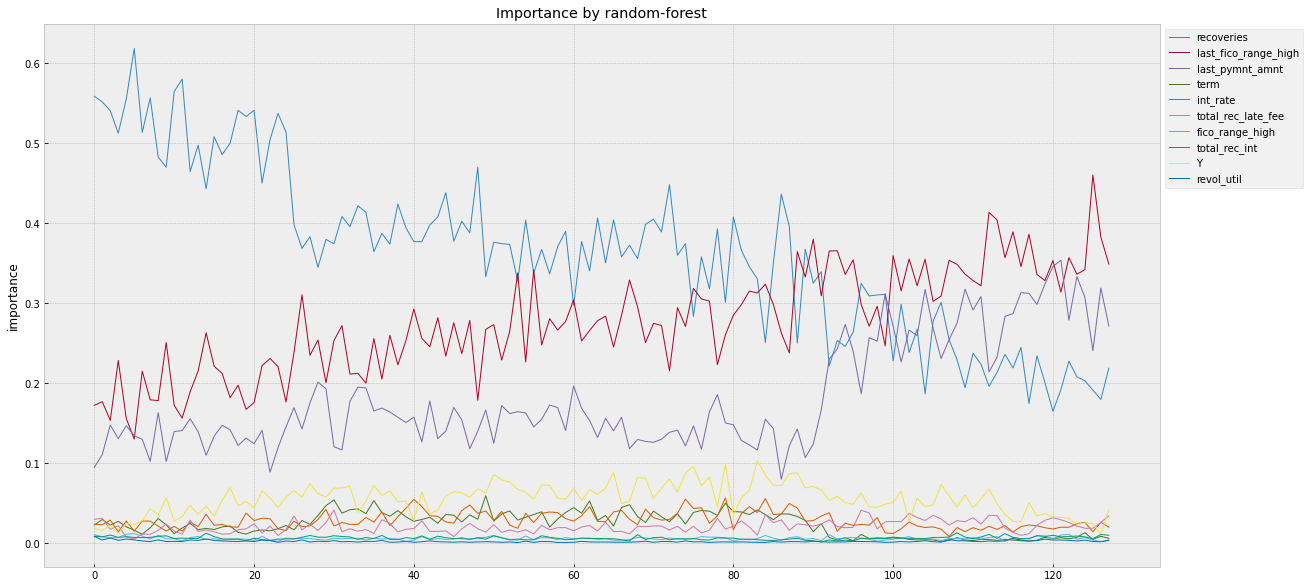

In [ ]:
ax = imp_df_rf[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by random-forest",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

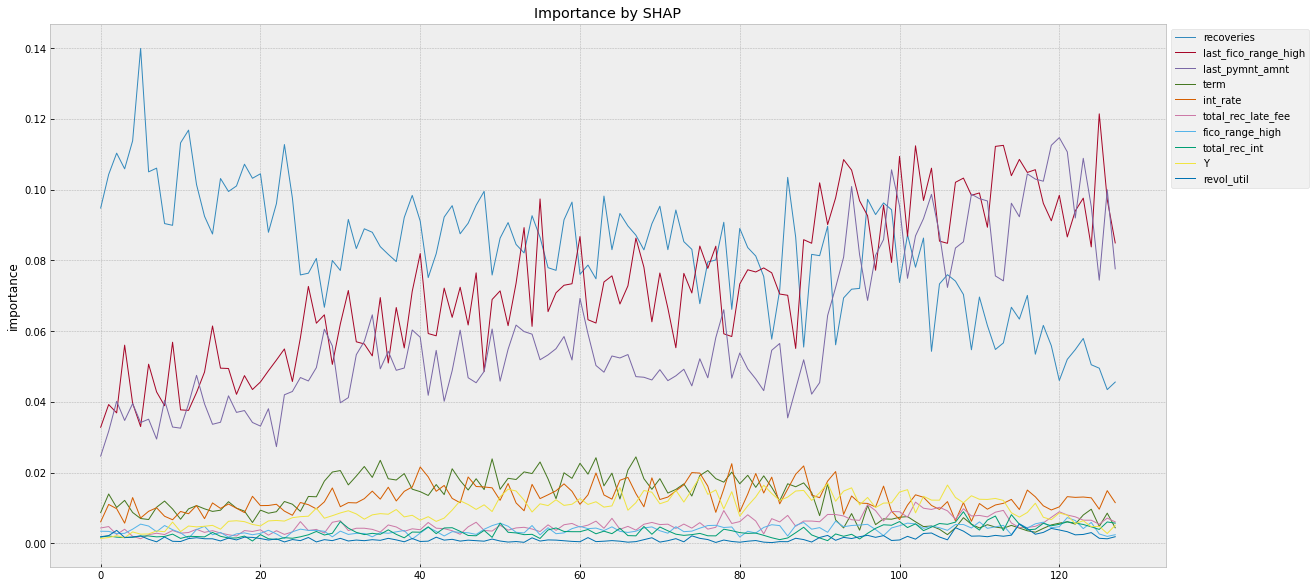

In [ ]:
ax = imp_df_sh[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by SHAP",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

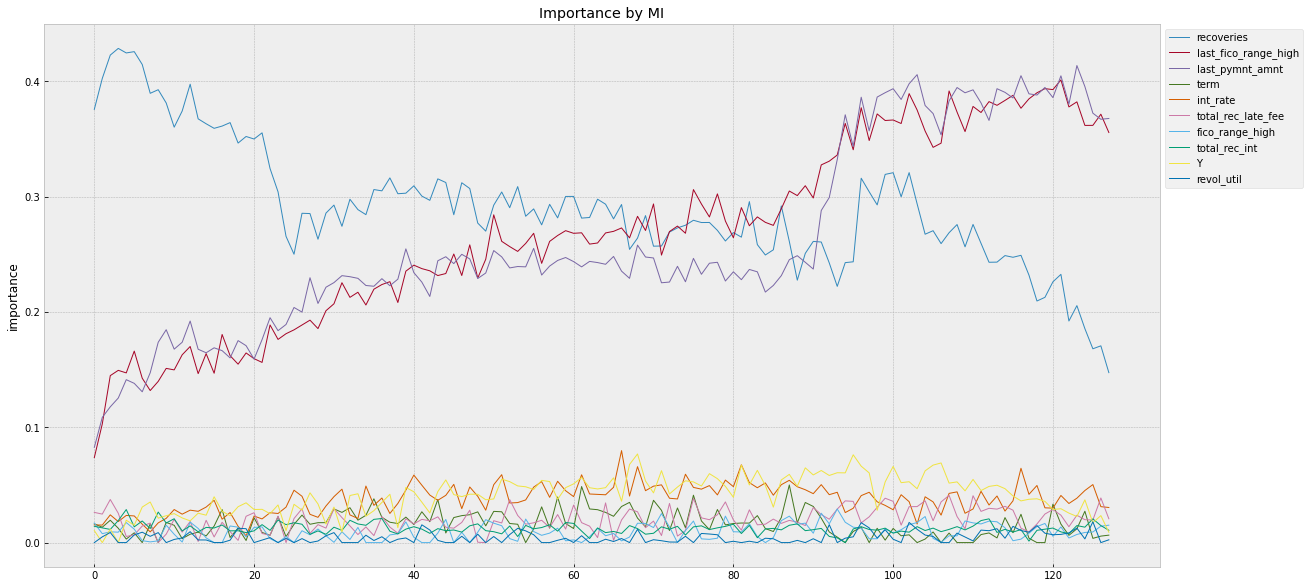

In [ ]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## 예측 Y에 의한 importance 측정

In [ ]:
batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['prec'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#Random-forest
predict = ML[REFERENCE_YEAR].predict
importances = ML[REFERENCE_YEAR].feature_importances_
#imp_df = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

imp_df_rf = pd.DataFrame(importances.reshape(1,-1),columns=COLUMNS)

# SHAP
explainer = shap.TreeExplainer(ML[2010])
shap_values = explainer.shap_values(scaler.transform(x_ref))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)
imp_df_sh = pd.DataFrame(feature_importance)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    Y3_ = predict(scaler.transform(X3))
    f1 = precision_recall_fscore_support(Y3, Y3_ ,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['prec'].append(f1[0])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    scaler = MinMaxScaler()
    scaler.fit(X3)
    X3_f = scaler.transform(X3)

    # RF
    model2 = RandomForestClassifier(n_estimators=80,max_depth=5)
    model2.fit(X3_f,Y3_)
    imp_df_rf.loc[len(imp_df_rf)] = model2.feature_importances_
    # SHAP
    explainer = shap.TreeExplainer(model2)
    shap_values = explainer.shap_values(X3_f)
    vals= np.abs(shap_values).mean(0)
    imp_df_sh.loc[len(imp_df_sh)] = np.mean(vals,axis=0).reshape(-1,)
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(X3_f,columns=COLUMNS), Y3_, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} prec:{f1[0]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)

127/127 prec:0.8719

[]

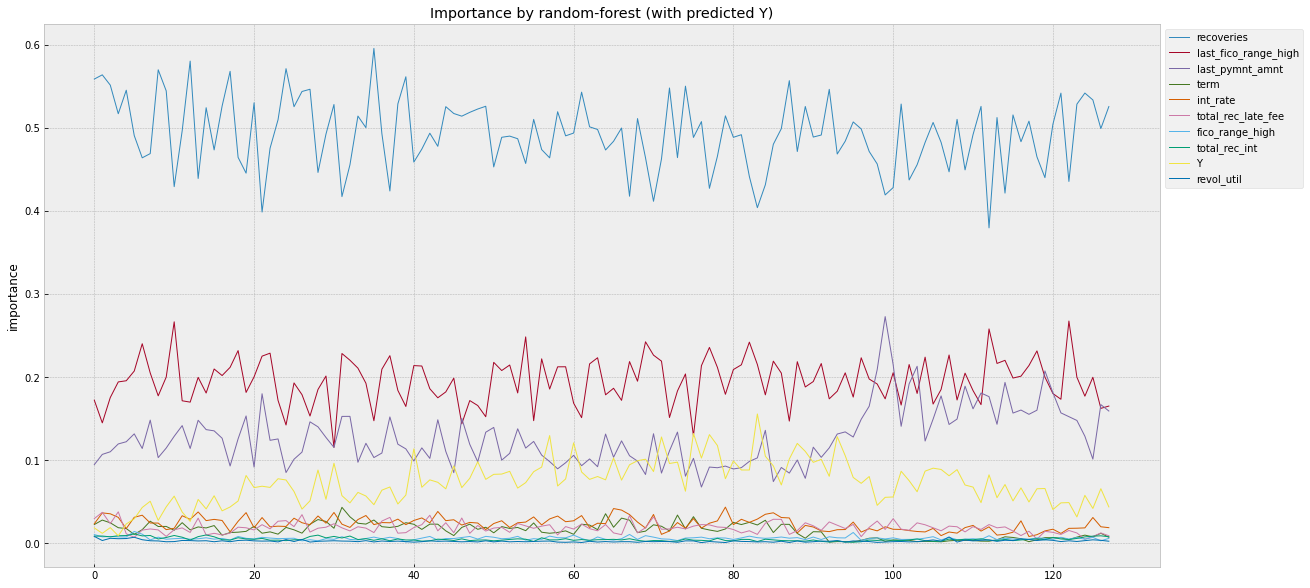

In [ ]:
ax = imp_df_rf[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by random-forest (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

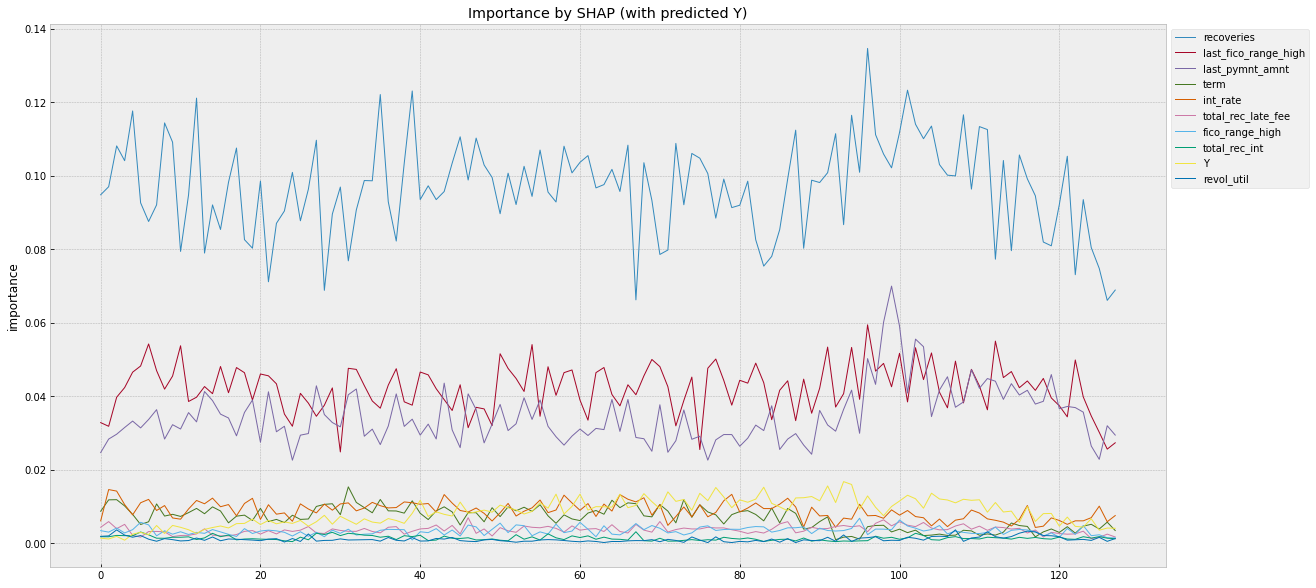

In [ ]:
ax = imp_df_sh[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by SHAP (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

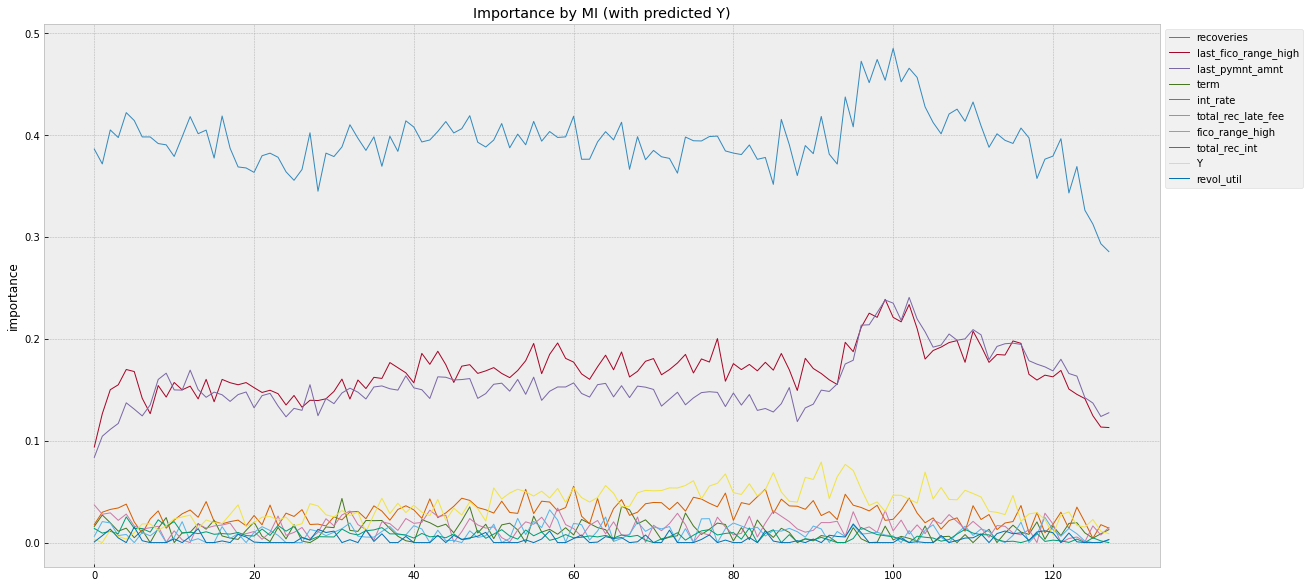

In [ ]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## Deep learning 모델의 실험

In [100]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])
     

In [101]:
import os.path 

def build_model_dl(year,x,y,epochs=5,verbose=1):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=81*2,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    """
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    """
    model.fit(x=X_train, 
            y=y_train, 
            epochs=epochs,
            batch_size=512,
            verbose=verbose)
        #validation_data=(X_test, y_test), verbose=1)


    return model

In [102]:
get_one_hot(y_ref[0:10],2)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [103]:
scaler = MinMaxScaler()
scaler.fit(x_ref)

deep_model = build_model_dl(2010,x_ref,y_ref,epochs=100)

Epoch 1/100
16/16 [==============================] - 2s 3ms/step - loss: 0.4795 - accuracy: 0.8721
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3799 - accuracy: 0.8721
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3593 - accuracy: 0.8721
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3471 - accuracy: 0.8721
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3356 - accuracy: 0.8721
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8721
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3138 - accuracy: 0.8724
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.8744
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2871 - accuracy: 0.8803
Epoch 10/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2697 - accuracy: 0.8880
Epoch 11/

#### deep 모델에 대한 Test

In [104]:
x_inf.shape

(3450, 81)

In [105]:
import shap
import sys

scaler = MinMaxScaler()
scaler.fit(x_ref)

background = x_ref[np.random.choice(x_ref.shape[0], 100, replace=False)]
sample_inf = x_inf[np.random.choice(x_inf.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(deep_model,scaler.transform(background))
shap_values = explainer.shap_values(scaler.transform(sample_inf))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

/usr/local/lib/python3.8/dist-packages/shap/explainers/_deep/deep_tf.py:95: UserWarning:

keras is no longer supported, please use tf.keras instead.

/usr/local/lib/python3.8/dist-packages/shap/explainers/_deep/deep_tf.py:100: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

array([[0.20833333, 0.        , 0.37422935, ..., 0.        , 0.        ,
        0.        ],
       [0.45833333, 0.        , 0.15166461, ..., 1.        , 0.        ,
        0.        ],
       [0.10416667, 0.        , 0.39704069, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.20833333, 0.        , 0.30579531, ..., 1.        , 0.        ,
        0.        ],
       [0.58333333, 0.        , 0.58816276, ..., 0.        , 0.        ,
        0.        ],
       [0.08333333, 0.        , 0.48150432, ..., 1.        , 0.        ,
        0.        ]])>]. Consider

,last_pymnt_amnt,recoveries,last_fico_range_high,total_rec_int,loan_amnt,MORTGAGE,RENT,int_rate,term,Y
0,0.057678,0.051439,0.0448,0.044211,0.041524,0.041217,0.03471,0.029972,0.016819,0.015431


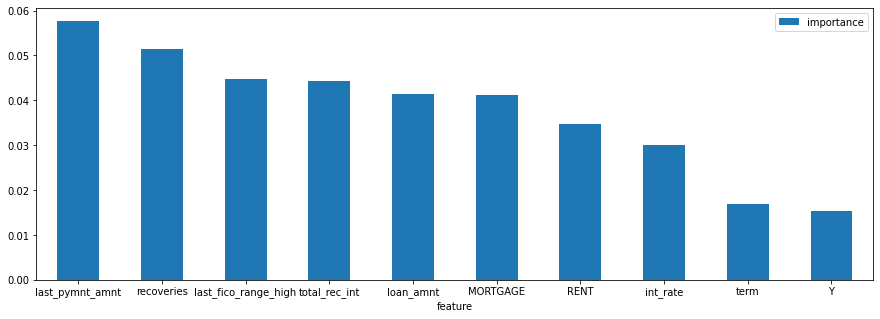

In [106]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))

In [107]:
import shap
import sys

scaler = MinMaxScaler()
scaler.fit(x_ref)

x_reff = scaler.transform(x_ref)
x_inff = scaler.transform(x_inf)

background = shap.utils.sample(x_reff, 100)

explainer = shap.Explainer(deep_model.predict,background)
shap_values = explainer.shap_values(np.asarray(x_inff))
vals= np.abs(shap_values).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,np.mean(vals,axis=0)):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)

sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

AttributeError: ignored

#### KernelSHAP

In [115]:
explainer = shap.KernelExplainer(deep_model.predict,background)

kernel_x = shap.utils.sample(x_reff, 20)

shap_values = explainer.shap_values(kernel_x)


4/4 [==============================] - 0s 2ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

6782/6782 [==============================] - 8s 1ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To rep

In [116]:
vals= np.abs(shap_values[1]).mean(0)
feature_importance = {}
for (fname,imp_val) in zip(COLUMNS,vals):
    feature_importance[fname] = [imp_val] # (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)

imp_df2 = pd.DataFrame(feature_importance)
sorted_feature = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1][0],reverse=True)}
top = 10
monitoring_feature = np.array(list(sorted_feature.keys()))[0:top]
imp_df2[monitoring_feature]

,last_pymnt_amnt,loan_amnt,total_rec_int,RENT,last_fico_range_high,MORTGAGE,recoveries,OWN,int_rate,Y
0,0.101109,0.09757,0.083104,0.073851,0.07063,0.065912,0.049828,0.042431,0.033305,0.024008


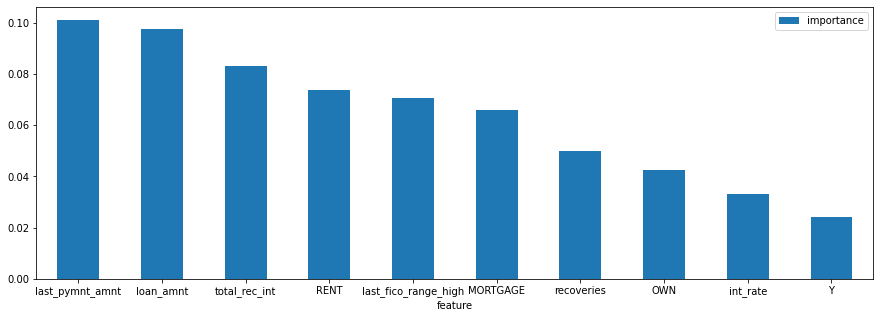

In [117]:
df = pd.DataFrame({'feature':monitoring_feature, 'importance':imp_df2[monitoring_feature].values[0]})
df.plot.bar(x='feature',rot=0,figsize=(15,5))

In [88]:
from interpret import show
from interpret.blackbox import ShapKernel
import shap

scaler = MinMaxScaler()
scaler.fit(x_ref)

x_reff = scaler.transform(x_ref)
background = shap.utils.sample(x_reff, 100)

shapk = ShapKernel(predict_fn=deep_model.predict, data=background)
shap_local = shapk.explain_local(x_reff[:1],y_ref[:1],name=COLUMNS)



4/4 [==============================] - 0s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:133: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 



In [89]:
show(shap_local)

ERROR:interpret.visual.interactive:Object of type Index is not JSON serializable
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/interpret/visual/interactive.py", line 169, in show
    this.visualize_provider.render(explanation, key=key, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/interpret/provider/visualize.py", line 58, in render
    self.provider.render(explanation, key=key, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/interpret/provider/visualize.py", line 219, in render
    render(
  File "/usr/local/lib/python3.8/dist-packages/interpret/visual/inline.py", line 232, in render
    init_js, body_js = _build_javascript(
  File "/usr/local/lib/python3.8/dist-packages/interpret/visual/inline.py", line 191, in _build_javascript
    div_id, json.dumps(viz_obj), default_key
  File "/usr/lib/python3.8/json/__init__.py", line 231, in dumps
    return _default_encoder.encode(obj)
  File "/usr/lib/python3.8/json/encoder.py", line 199

TypeError: ignored

In [ ]:
import math

batch_size = 10000
batch = math.ceil(X2.shape[0]/batch_size)
df = {}
df['f1'] = []
#df['f1_c'] = []
REFERENCE_YEAR = 2010
scaler = MinMaxScaler()
scaler.fit(x_ref)

#MI
mi_scores = make_mi_scores(pd.DataFrame(scaler.transform(x_ref),columns=COLUMNS), y_ref, discrete_features=discrete_features)
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]


for i in range(batch):
    X3 = X2[i*batch_size:(i+1)*batch_size]
    Y3 = Y2[i*batch_size:(i+1)*batch_size]
    X3_ = scaler.transform(X3)
    Y3_ = deep_model.predict(X3_,verbose=0)
    Y4_ = np.asarray([0 if _Y[0] > 0.5 else 1 for _Y in Y3_])
    #print(Y3[0:10])
    #print(Y4_[0:10])
    
    f1 = precision_recall_fscore_support(Y3,Y4_,average='binary')
    #X3_drift = ks_drift(x_ref,X3)[:,0]
    #acc_c = model_c.predict(X3_drift.reshape(1,-1))[0]

    #print(f"{f1[2]}, {acc_c[2]}")
    df['f1'].append(f1[2])
    #df['f1_c'].append(acc_c[2])

    #################  importance 측정

    #scaler = MinMaxScaler()
    #scaler.fit(X3)

    # remodeling
    #model2 = build_model_dl(2010,X3,Y4_,epochs=100,verbose=0)

    #MI
    mi_scores = make_mi_scores(pd.DataFrame(X3_,columns=COLUMNS), Y4_, discrete_features=discrete_features)
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    print(f"\r{i+1}/{batch} f1:{f1[2]:.4f}", end="", flush=True)


df1 = pd.DataFrame(df)



127/127 f1:0.9589

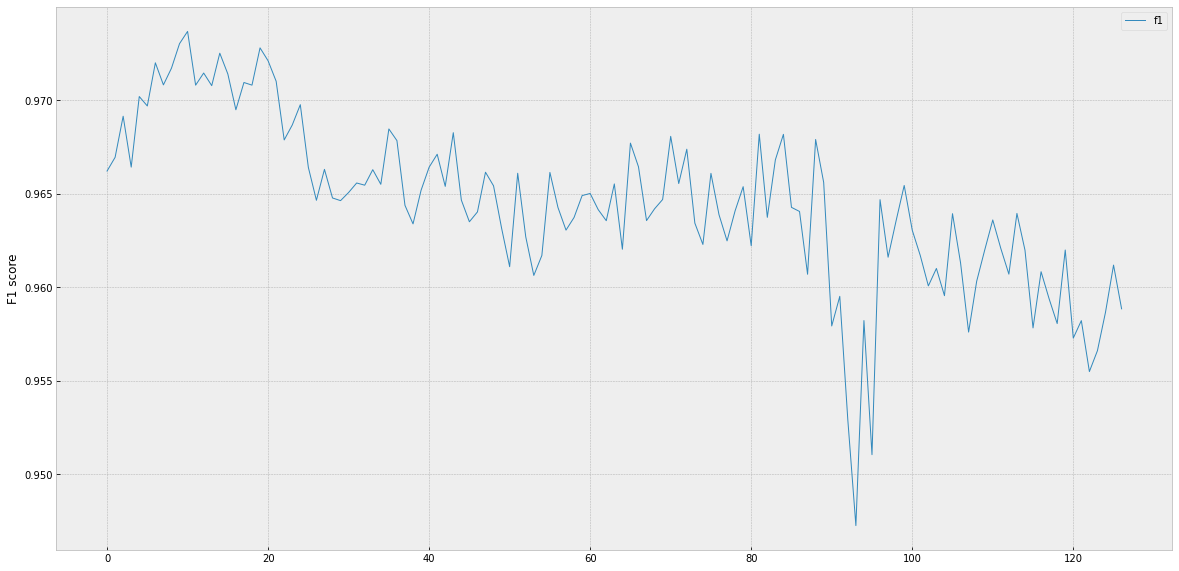

In [ ]:
plt.style.use('bmh')
df1.plot(ylabel='F1 score',linewidth=1,figsize=(20,10))

[]

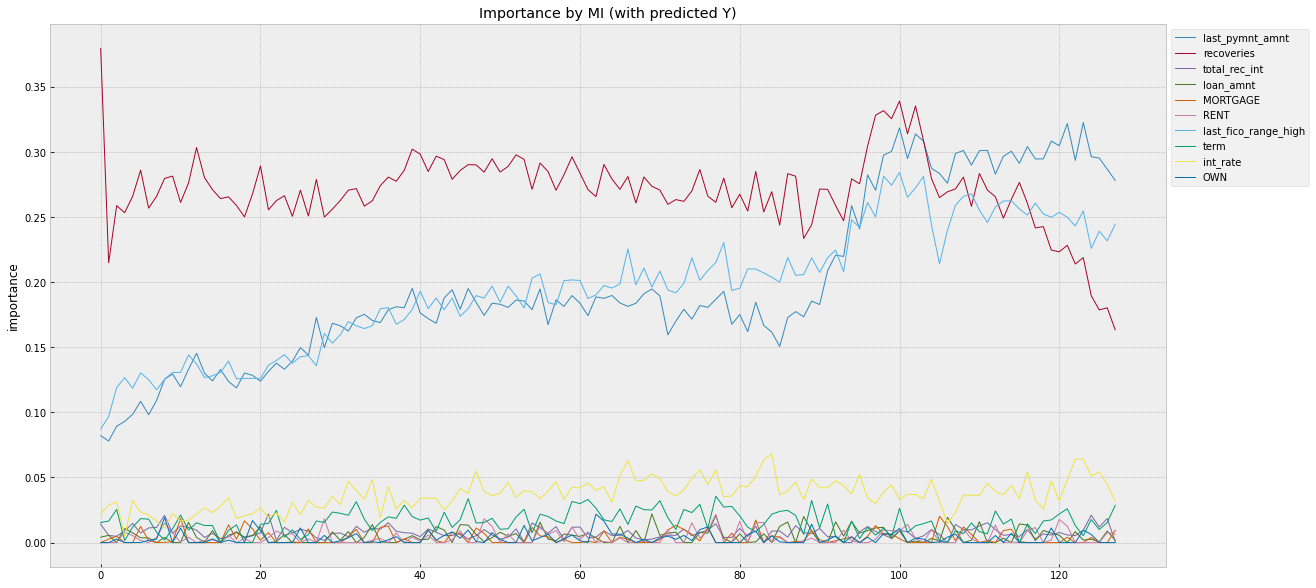

In [ ]:
ax = imp_df_mi[monitoring_feature].plot(ylabel='importance',linewidth=1,figsize=(20,10),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()